In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from timeit import default_timer as timer
import peakutils


/home/sam/tensorflow/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.



## Generate sine wave data points

In [2]:
#Define characteristics of the data to generate
num_cycles = 20
sample_rate = 0.4
points_per_cycle = int((2*np.pi) / sample_rate)*10


x_range = np.arange(start=-np.pi/2, stop=80*2*np.pi, step=sample_rate)
print(max(x_range))
mult_start = 0.9
mult_end = 0.7
mult_range = mult_end - mult_start

period_multiplier = np.arange(mult_start, mult_end, mult_range/len(x_range))
#b = np.arange(0.5, 1, 1/len(a))
data = [np.sin(i*j) for i,j in zip(x_range, period_multiplier)]
#Shift the dataset up so we can use -1 as our NaN value
shiftData = [data[i] + -min(data) for i in range(len(data))] 
data = shiftData

print("Total data points: " + str(len(data)))



502.429203673205
Total data points: 1261


## Grab the start and end points of each cycle

In [3]:
#Negate force values to find a trough using the same peak function
negated_vals = [-i for i in data]

#Grab the peak and trough times (these are also indices)
peak_times = peakutils.indexes(data, thres=0.5, min_dist=0.1)
trough_times = peakutils.indexes(negated_vals, thres=0.5, min_dist=0.1)

#Find the time's corresponding y value
peak_vals = [data[i] for i in peak_times]
trough_vals = [data[i] for i in trough_times]

print(len(peak_times))

56


## Plot the raw data

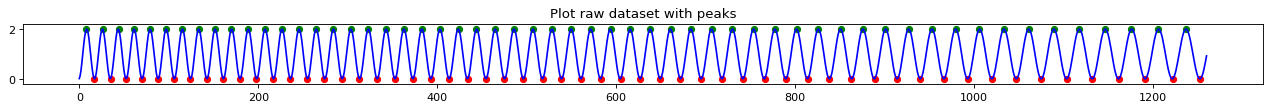

In [4]:
# (1) Plot whole dataset
fig=plt.figure(figsize=(20, 1), dpi= 80, facecolor='w', edgecolor='k')
#Line plot along the true data
plt.plot([x for x in range(len(data))], data, color="blue")
plt.title('Plot raw dataset with peaks')

#Plot the training points in green
plt.scatter(peak_times, peak_vals, color="green", s=30)
plt.scatter(trough_times, trough_vals, color="red", s=30)
plt.show()

## Generate a dataset using padding

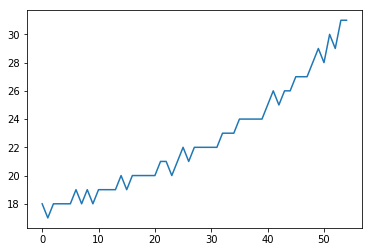

17
31
22


In [5]:
#Collect all the period values from the dataset
periods = []
for i in range(len(trough_times) - 1):
    period = trough_times[i+1] - trough_times[i]
    periods.append(period)
plt.plot(periods)
plt.show()

print(min(periods))
print(max(periods))
print(sum(periods)/len(periods))

In [6]:


#Always capture three full waves. A single wave is represented by peak-to-peak. So each example needs a 3 peaks pairs.

#To capture cycles without starting and ending at only peaks each time, 
# use percentages of points realtive to the distance(num points) between the two peaks.
# so if an example starts n points before the first peak, then use n/(n_cyle_points) as the num points to use ahead



"""
Algorithm

3 periods is given by: counting points up until first peak (P), then going until 3 peaks have passed
and adding P more points to the end. 


1. Init containers for examples (holding Xs and Ys). Init pointer to step along ~1 point at a time


2. In Loop
    a. Aggregate and count how many points passed before first peak seen. Set this value as int "passed".
    b. Continue collecting points until 3 peaks seen. Then proceed for another "passed" points. Done.    


3.Last stage should just pad each example so they're all of the same dimension
    
    
    Use percentage offset of points from a peak to approximate where to end. 
        (for example that doesnt perfectly capture all peaks)




***Maybe idea is that it should always have at least enough peaks to form n-1 waves and 
extrapolate the rest based on previously seen info

Maybe should always see n peaks, and expand if not

"""





'\nAlgorithm\n\n3 periods is given by: counting points up until first peak (P), then going until 3 peaks have passed\nand adding P more points to the end. \n\n\n1. Init containers for examples (holding Xs and Ys). Init pointer to step along ~1 point at a time\n\n\n2. In Loop\n    a. Aggregate and count how many points passed before first peak seen. Set this value as int "passed".\n    b. Continue collecting points until 3 peaks seen. Then proceed for another "passed" points. Done.    \n\n\n3.Last stage should just pad each example so they\'re all of the same dimension\n    \n    \n    Use percentage offset of points from a peak to approximate where to end. \n        (for example that doesnt perfectly capture all peaks)\n\n\n\n\n***Maybe idea is that it should always have at least enough peaks to form n-1 waves and \nextrapolate the rest based on previously seen info\n\nMaybe should always see n peaks, and expand if not\n\n'

## Example generation with pandas dataframe 

In [25]:
def generate_dataset(data, peak_times, trough_times, x_cycles=5, y_cycles=1):
    """
    - Each X and label is "set" in size (will contain variable num of useless datapoints at end)
    - So we combine these adjacent to one another and stack all examples vertically 
    TODO: We should make the length grow from the inside out; the prev points should extend backwards?***
    #TODO: Maybe dont split the train inside here, maybe just output a train and test var
    #TODO: Try testing on earlier wave? See if it just predicts something smaller than later wave? 
       We cant use seen data already, so maybe dont train on first 4 waves, and dont train on last 4 waves.
    """
    #Set some variables to use
    smallest_period = peak_times[1] - peak_times[0]
    largest_period = peak_times[-1] - peak_times[-2]
    print("Smallest Period: " + str(smallest_period))
    print("Largest Period: " + str(largest_period))
    period_range = largest_period - smallest_period
    holder_size = int(largest_period * 1.4)
    print("HOLDER Size: " + str(holder_size))
    print("")
    #--------Grab the data to be used for testing, so it doesnt contaminate at all----------
    
    #Calculate using peaks how much data we need for x_cycles + y_cycles
    
    #Collect enough points to see x_cycles + y_cycles periods & start halfwave in between peak and trough
    num_test_cycles = x_cycles + y_cycles
    start_peak_time = peak_times[-num_test_cycles]
    one_trough_prior_time = trough_times[-(num_test_cycles+1)]
    
    
    test_in_start = int(start_peak_time - (start_peak_time - one_trough_prior_time))
    print(test_in_start)

    #Find when test_in ends and test_out starts
    #Between the second-to-last trough and last peak
    snd_to_last_trough = trough_times[-2]
    last_peak = peak_times[-1]
    test_out_start = int(last_peak - (last_peak - snd_to_last_trough))
    print(test_out_start)
    
    
    print("---------------------Finding test set size-----------------------")
    print("test_start_time: " + str(test_in_start))
    print("len total data: " + str(len(data)))
    print("")
    test_in = data[test_in_start:test_out_start]
    test_out = data[test_out_start:]
    
    #Remove this test data from the train set
    data = data[:test_in_start]
    
    #Store the test data within the default containers
    test_in_container = [-1]* (holder_size*x_cycles)
    print("unpopulated test_in_container size: " + str(len(test_in_container)))
    test_in_container[-len(test_in):] = test_in
    print("populated test_in_container size: " + str(len(test_in_container)))
    print("actual test_in data size: " + str(len(test_in)))

    print("")
    
    
    test_out_container = [-1]* (holder_size*y_cycles)
    print("unpopulated test_out_container size: " + str(len(test_out_container)))
    test_out_container[:len(test_out)] = test_out
    print("unpopulated test_out_container size: " + str(len(test_out_container)))
    print("actual test_out data size: " + str(len(test_out)))
    

    
    print("len test_in: " + str(len(test_in)))
    print("len test_out: " + str(len(test_out)))

    print("len train data: " + str(len(data)))
    print("")

    
    
    
#     num_test_points = holder_size* (x_cycles + y_cycles)
#     test = data[-num_test_points:]
#     data = data[:-num_test_points]
    
    
    
    #holder_size = default_period
    #Assign an approximate period-value to each point over the distribution from smallest to largest
    approx_periods = [int(smallest_period + i) for i in np.linspace(0, period_range, len(data))]
    
    #Set the variable number of points to use on first iteration
    n_prev = smallest_period * x_cycles
    n_forecast = smallest_period * y_cycles
    
    
    #Init the pandas dataframe to hold our new dataset (TODO!!! probably modularize into seperate function)
    col_names = list()

    for i in range(holder_size*x_cycles, 0, -1):
        col_names += ['var(t-%d)' %  i]
    
    for i in range(0, holder_size*y_cycles):
        if i == 0:
            col_names += ['var(t)']
        else:
            col_names += ['var(t+%d)' % i]

    df = pd.DataFrame(columns = col_names)
    
    print("Just after creation, the df is shape: " + str(df.shape))
    
    #Loop over the data and convert into samples
    for i in range(len(data)):
        #print("----------In Loop: i= "+str(i)+" ---------------------" )
        
        #Exit if we dont have enough points remaining to construct another example
        if((i+n_prev) > len(data) or (i+n_prev+n_forecast) > len(data)):
            print("we're breaking!")
            break
        
        #Init our examples input and label (TODO!!! combine these lines into one as x & y in same row now)
        x = [-1]* (holder_size*x_cycles)
        #print("x size: " +str(len(x)))
        y = [-1]* (holder_size*y_cycles)
        #print("y size: " +str(len(y)))

        #print("X is of size: " + str(len(x)))
        
        #Set real values in the default size holders
        #print("LOOK HERE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        #print(len(x[-n_prev:]))
        #print(len(data[i:i+n_prev]))
        x[-n_prev:] = data[i:i+n_prev] #Store at the end of the array
        y[:n_forecast] = data[i+n_prev:i+n_prev+n_forecast] #Store at the beginning of the array
        
        #Add the x & y pair as a row in the dataframe
        df.loc[i] = x + y 
        
        #Calculate the new period to use
        new_period_size = int(np.average(approx_periods[i:i+n_prev]))
        n_prev = new_period_size*3
        n_forecast = new_period_size
        #print("new period size: " + str(new_period_size))
        

    print("num points: " +str(len(data)))
    print("dataframe shape:" + str(df.shape))

    #Set the figure parameters
    #fig=plt.figure(figsize=(20, 2), dpi= 80, facecolor='w', edgecolor='k')

    len_final_example = n_prev + n_forecast
    
    #Remeber: iloc works with weird indexing: [rows, cols]
    #First index is rows and second is columns
    
    #train_examples = df.iloc[:-1, :holder_size*x_cycles]
    #train_labels = df.iloc[:-1, holder_size*x_cycles:]
    
    #test_example = df.iloc[-1, :holder_size*x_cycles]
    #test_label = df.iloc[-1, holder_size*x_cycles:]

    #Return the training dataframe, the test vector, and the default holder size
    return df, test_in_container, test_out_container, holder_size, x_cycles, y_cycles

    
    #return train_examples,train_labels, test_example, test_label, sizzzzzze

## Building the dataset

In [33]:
# new_exper_data = [i for i in range(30)]
# default_period = 5
# new_exper_peak_times = [0,1,2,4,6,8,11, 13, 16, 18, 21, 25, 30 ]

#train_examples, train_labels, test_example, test_label = generate_dataset(data, peak_times)
df_train, test_in, test_out, holder_size, x_cycles, y_cycles = generate_dataset(data, peak_times, trough_times)

print("df_train: " + str(df_train.shape))
train_examples = df_train.iloc[:, :holder_size*x_cycles]
train_labels = df_train.iloc[:, holder_size*x_cycles:]

#test_example = test_array[:holder_size*3]
#test_label = test_array[:holder_size*3]
print("")
print("HERE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
print("train_examples: " + str(train_examples.shape))
print("train_labels: "+ str(train_labels.shape))
print("")
print("len test_in: " + str(len(test_in)))
print("len test_out: " + str(len(test_out)))
print(holder_size)


# print("test_example: "+ str(len(test_example)))
# print("test_label: " + str(len(test_label)))

# print(test_example.iloc[100:105])
# print(train_examples.iloc[-1,100:105])
#print(test_example)
#print(test_label)

Smallest Period: 18
Largest Period: 31
HOLDER Size: 43

1075
1222
---------------------Finding test set size-----------------------
test_start_time: 1075
len total data: 1261

unpopulated test_in_container size: 215
populated test_in_container size: 215
actual test_in data size: 147

unpopulated test_out_container size: 43
unpopulated test_out_container size: 43
actual test_out data size: 39
len test_in: 147
len test_out: 39
len train data: 1075

Just after creation, the df is shape: (0, 258)
we're breaking!
num points: 1075
dataframe shape:(960, 258)
df_train: (960, 258)

HERE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
train_examples: (960, 215)
train_labels: (960, 43)

len test_in: 215
len test_out: 43
43


## Define LSTM architecture

* NOTE: We have to switch the input such that 2nd dimension (time_steps) is representative of how many steps to look into the past.  
* NOTE: "features" is dim 1. It is just representative of the number of dimensions in our input, nothing to do with number of points, nor the number of points on the output.

In [34]:
# fit an LSTM network to training data

def fit_lstm(X, y, n_batch, nb_epoch, n_neurons):
    """
    Function to convert data so it can be interpreted by the LSTM and then trains and returns the LSTM model
    Note: 
    
    Input to every LSTM layer must be 3 dimensional
    - Samples: one sequence is one sample. A batch is comprised of 1 or more samples.
    - Time Steps: One time step is one point of observation in the sample.
    - Features: One feature is one observation at a time step.
    
    """
    
    architecture = ""
    # reshape training into [samples, timesteps, features]
    
    #Split the training data into X (input) and y (labels)
    #X, y = train[:, 0:n_prev], train[:, n_prev:]

    print("X shape: " + str(X.shape))
    print("y shape: " + str(y.shape))
    
    #Reshape X so Samples=num_examples, TimeSteps=1, Features = n_lag
    #X = X.reshape(X.shape[0], 1, X.shape[1]) !!!!
    X = X.reshape(X.shape[0],X.shape[1],1)
    

    model = Sequential()
    #We feed in batch sizes of dimension: (n_batch, 1, n_lag)
    print("sam")
    print((n_batch, X.shape[1], X.shape[2]))
    print(X.shape)
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=False))
    architecture += "LSTM; "
    #model.add(Dense(300))
    #Last layer is a fully connected layer to output size n_forecast
    model.add(Dense(y.shape[1]))
    architecture += "Dense output; "
    #Compile the network
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    #Fit the network to the training data
    history = model.fit(X, y, epochs=nb_epoch, batch_size=n_batch, verbose=1, shuffle=False)
    

    return model, architecture, history

In [35]:
#Cut off some training data if necessary for batch sizes
print(train_examples.shape)
train_examples_cut = train_examples[:]
print(train_examples_cut.shape)

print(train_labels.shape)
train_labels_cut = train_labels[:]
print(train_labels_cut.shape)

print("Here")
print(train_examples_cut.shape)
print(train_labels_cut.shape)

(960, 215)
(960, 215)
(960, 43)
(960, 43)
Here
(960, 215)
(960, 43)


## Train the Neural Network

In [36]:
n_epochs = 1000
n_batch = 120
n_neurons = 60
#print("train shape: " + str(train.shape))
#train_cut = train[:-2,:]
#train_cut = train
#print("train shape: " + str(train_cut.shape))
print("train shape: " +str(train.shape))
model, architecture, history = fit_lstm(train_examples_cut.values, train_labels_cut.values, n_batch, n_epochs, n_neurons)


train shape: (960, 215)
X shape: (960, 215)
y shape: (960, 43)
sam
(120, 215, 1)
(960, 215, 1)
Epoch 1/1000
960/960 [==============================] - 2s 2ms/step - loss: 1.2060 - acc: 0.0417
Epoch 2/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.9674 - acc: 0.0531
Epoch 3/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.6371 - acc: 0.0385
Epoch 4/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.5057 - acc: 0.0438
Epoch 5/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.4654 - acc: 0.0260
Epoch 6/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.4563 - acc: 0.0302
Epoch 7/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.4473 - acc: 0.0563
Epoch 8/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.4422 - acc: 0.1156
Epoch 9/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.4363 - acc: 0.0979
Epoch 10/1000
960/960 [=========

960/960 [==============================] - 2s 2ms/step - loss: 0.1478 - acc: 0.2542
Epoch 84/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.1399 - acc: 0.3292
Epoch 85/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.1781 - acc: 0.1823
Epoch 86/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.1454 - acc: 0.3042
Epoch 87/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.1454 - acc: 0.3406
Epoch 88/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.1478 - acc: 0.2823
Epoch 89/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.1366 - acc: 0.2781
Epoch 90/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.1886 - acc: 0.1979
Epoch 91/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.1382 - acc: 0.2583
Epoch 92/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.1212 - acc: 0.3396
Epoch 93/1000
960/960 [===========

960/960 [==============================] - 2s 2ms/step - loss: 0.0710 - acc: 0.4135
Epoch 167/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0776 - acc: 0.3562
Epoch 168/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0759 - acc: 0.4167
Epoch 169/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0920 - acc: 0.3479
Epoch 170/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0881 - acc: 0.4198
Epoch 171/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0695 - acc: 0.4219
Epoch 172/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0704 - acc: 0.4375
Epoch 173/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0724 - acc: 0.4010
Epoch 174/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0722 - acc: 0.4521
Epoch 175/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0688 - acc: 0.4052
Epoch 176/1000
960/960 [=

960/960 [==============================] - 2s 2ms/step - loss: 0.0676 - acc: 0.4208
Epoch 249/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0824 - acc: 0.2979
Epoch 250/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0671 - acc: 0.4208
Epoch 251/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0643 - acc: 0.4052
Epoch 252/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0576 - acc: 0.5031
Epoch 253/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0598 - acc: 0.4198
Epoch 254/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0575 - acc: 0.4396
Epoch 255/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0540 - acc: 0.4115
Epoch 256/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0528 - acc: 0.4635
Epoch 257/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0558 - acc: 0.3635
Epoch 258/1000
960/960 [=

960/960 [==============================] - 2s 2ms/step - loss: 0.0378 - acc: 0.4594
Epoch 331/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0369 - acc: 0.4885
Epoch 332/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0364 - acc: 0.4490
Epoch 333/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0353 - acc: 0.4958
Epoch 334/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0347 - acc: 0.4750
Epoch 335/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0341 - acc: 0.4750
Epoch 336/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0338 - acc: 0.5042
Epoch 337/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0341 - acc: 0.4594
Epoch 338/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0344 - acc: 0.4927
Epoch 339/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0352 - acc: 0.4667
Epoch 340/1000
960/960 [=

960/960 [==============================] - 2s 2ms/step - loss: 0.0285 - acc: 0.5208
Epoch 413/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0283 - acc: 0.5125
Epoch 414/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0281 - acc: 0.5187
Epoch 415/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0279 - acc: 0.5135
Epoch 416/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0278 - acc: 0.5260
Epoch 417/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0277 - acc: 0.5281
Epoch 418/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0276 - acc: 0.5292
Epoch 419/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0274 - acc: 0.5229
Epoch 420/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0274 - acc: 0.5198
Epoch 421/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0274 - acc: 0.5365
Epoch 422/1000
960/960 [=

960/960 [==============================] - 2s 2ms/step - loss: 0.0523 - acc: 0.4719
Epoch 495/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0806 - acc: 0.3625
Epoch 496/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0763 - acc: 0.4302
Epoch 497/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.1034 - acc: 0.3583
Epoch 498/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0789 - acc: 0.3937
Epoch 499/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0636 - acc: 0.3938
Epoch 500/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0570 - acc: 0.3802
Epoch 501/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0422 - acc: 0.4552
Epoch 502/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0388 - acc: 0.4688
Epoch 503/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0357 - acc: 0.4844
Epoch 504/1000
960/960 [=

960/960 [==============================] - 2s 2ms/step - loss: 0.0562 - acc: 0.4260
Epoch 577/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0457 - acc: 0.5792
Epoch 578/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0376 - acc: 0.5177
Epoch 579/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0357 - acc: 0.4646
Epoch 580/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0325 - acc: 0.5573
Epoch 581/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0311 - acc: 0.5729
Epoch 582/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0280 - acc: 0.5229
Epoch 583/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0253 - acc: 0.5583
Epoch 584/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0240 - acc: 0.5542
Epoch 585/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0233 - acc: 0.5573
Epoch 586/1000
960/960 [=

960/960 [==============================] - 2s 2ms/step - loss: 0.0214 - acc: 0.5594
Epoch 659/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0215 - acc: 0.5760
Epoch 660/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0210 - acc: 0.5719
Epoch 661/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0208 - acc: 0.5604
Epoch 662/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0201 - acc: 0.5875
Epoch 663/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0197 - acc: 0.5469
Epoch 664/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0192 - acc: 0.6000
Epoch 665/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0188 - acc: 0.5260
Epoch 666/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0184 - acc: 0.5979
Epoch 667/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0182 - acc: 0.5479
Epoch 668/1000
960/960 [=

960/960 [==============================] - 2s 2ms/step - loss: 0.0234 - acc: 0.5708
Epoch 741/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0213 - acc: 0.5625
Epoch 742/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0194 - acc: 0.6198
Epoch 743/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0207 - acc: 0.5260
Epoch 744/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0227 - acc: 0.6031
Epoch 745/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0209 - acc: 0.5708
Epoch 746/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0200 - acc: 0.5802
Epoch 747/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0189 - acc: 0.6281
Epoch 748/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0223 - acc: 0.5104
Epoch 749/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0272 - acc: 0.6062
Epoch 750/1000
960/960 [=

960/960 [==============================] - 2s 2ms/step - loss: 0.0284 - acc: 0.6479
Epoch 823/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0255 - acc: 0.6010
Epoch 824/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0245 - acc: 0.6417
Epoch 825/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0240 - acc: 0.6031
Epoch 826/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0244 - acc: 0.6458
Epoch 827/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0241 - acc: 0.5927
Epoch 828/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0240 - acc: 0.6385
Epoch 829/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0230 - acc: 0.5958
Epoch 830/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0225 - acc: 0.6323
Epoch 831/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0222 - acc: 0.5812
Epoch 832/1000
960/960 [=

960/960 [==============================] - 2s 2ms/step - loss: 0.0123 - acc: 0.6281
Epoch 905/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0122 - acc: 0.6042
Epoch 906/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0120 - acc: 0.6125
Epoch 907/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0119 - acc: 0.6094
Epoch 908/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0118 - acc: 0.6083
Epoch 909/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0117 - acc: 0.6167
Epoch 910/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0116 - acc: 0.6115
Epoch 911/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0116 - acc: 0.6042
Epoch 912/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0116 - acc: 0.6219
Epoch 913/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0116 - acc: 0.5906
Epoch 914/1000
960/960 [=

960/960 [==============================] - 2s 2ms/step - loss: 0.0130 - acc: 0.6469
Epoch 987/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0122 - acc: 0.6427
Epoch 988/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0116 - acc: 0.6365
Epoch 989/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0110 - acc: 0.6490
Epoch 990/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0106 - acc: 0.6198
Epoch 991/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0103 - acc: 0.6375
Epoch 992/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0101 - acc: 0.6240
Epoch 993/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0099 - acc: 0.6323
Epoch 994/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0098 - acc: 0.6271
Epoch 995/1000
960/960 [==============================] - 2s 2ms/step - loss: 0.0097 - acc: 0.6219
Epoch 996/1000
960/960 [=

## Display training progress

['acc', 'loss']


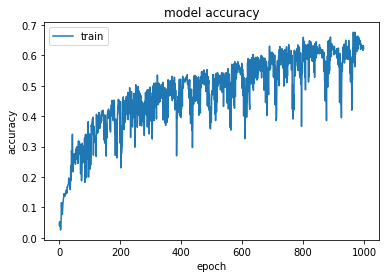

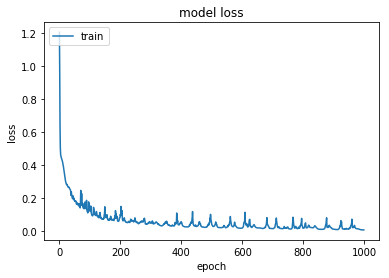

In [37]:
#list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [38]:
def forecast_lstm(model, X, n_batch):
    #Reshape input data to [samples, timesteps, features] for the LSTM
    
    Xs = [X for _ in range(n_batch)]
    
    x_stack = np.stack((Xs))
    print(x_stack.shape)
    
    X = x_stack.reshape(n_batch,len(X),1)
    
    #Make a forecast    
    forecast = model.predict(X, batch_size=n_batch)
    
    #Convert to array
    return [y_hat for y_hat in forecast[0,:]]

In [39]:
#Run on test data
#test_x, test_y = test[0:n_prev], test[n_prev:]
test_x, test_y = test_in, test_out#test_example.values, test_label.values
test_x = np.array(test_x)
print(len(test_x))
y_hat = forecast_lstm(model, test_x, n_batch)
print("First true label: " + str(test_y[0]))
print("First forecast: " +str(y_hat[0]))

print(len(test_x))
print(len(test_y))
print(len(y_hat))
RMSE = []
for i in range(33):
    RMSE.append(math.sqrt(mean_squared_error(test_y, y_hat)))
print("Average RMSE: ")
print(sum(RMSE)/len(RMSE))

215
(120, 215)
First true label: 0.0023954925814121397
First forecast: 0.008153781
215
43
43
Average RMSE: 
0.748084673797


## Plotting initial training data

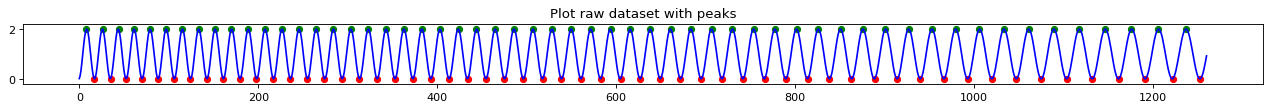

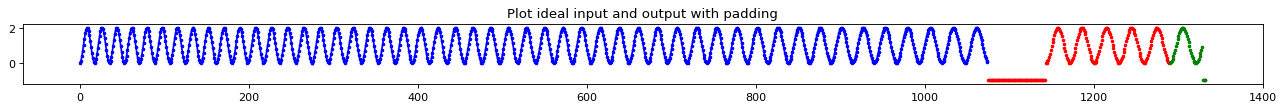

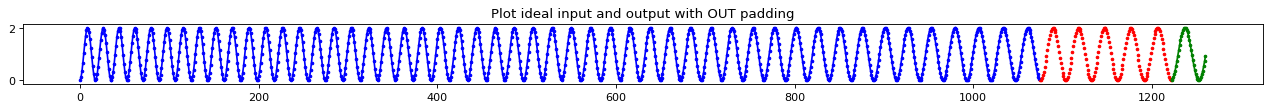

The true 'period' was: 39, and our predicted 'period' was: 28


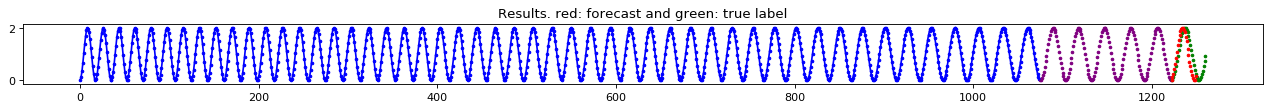

In [40]:
# (1) Plot whole dataset
fig=plt.figure(figsize=(20, 1), dpi= 80, facecolor='w', edgecolor='k')
#Line plot along the true data
plt.plot([x for x in range(len(data))], data, color="blue")
plt.title('Plot raw dataset with peaks')

#Plot the training points in green
plt.scatter(peak_times, peak_vals, color="green", s=30)
plt.scatter(trough_times, trough_vals, color="red", s=30)
plt.show()

# (2)--------------------------------------------------------------------------------------------

#Plotting the dataframe results
fig=plt.figure(figsize=(20, 1), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Plot ideal input and output with padding')

test_example = test_in
test_label = test_out


#Grab the data without padding
test_in_raw = test_example#.values 
test_in = [test_in_raw[i] for i in range(len(test_in_raw)) if test_in_raw[i] >= 0]
test_out_raw = test_label#.values
test_out = [test_out_raw[i] for i in range(len(test_out_raw)) if test_out_raw[i] >= 0]
test_len = len(test_in) + len(test_out) #default_period * 4

#Plot the training data and the underlying curve in blue 
train_plot_points= data[:-test_len]
plt.plot(train_plot_points, color="blue")
train_plot_x = [x for x in range(len(train_plot_points))]
plt.scatter(train_plot_x, train_plot_points, color="blue", s=5)

#Plot the test example X in red
test_input_plot_points = test_example#.values
test_input_xs = [x +len(train_plot_points) for x in range(len(test_input_plot_points))]
plt.scatter(test_input_xs, test_input_plot_points, color="red", s=5)

#Plot the test target label in green
test_label_points = test_label#.values
test_label_xs = [x +(len(train_plot_points)+len(test_input_plot_points)) for x in range(len(test_label_points))]
plt.scatter(test_label_xs, test_label_points, color="green", s=5)
plt.show()

# (3)--------------------To better visualize, we can also remove the unused padding-----------------------------

#Plotting the dataframe results
fig=plt.figure(figsize=(20, 1), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Plot ideal input and output with OUT padding')

#Plot the training data and the underlying curve in blue 
plt.plot(train_plot_points, color="blue")
plt.scatter(train_plot_x, train_plot_points, color="blue", s=5)

#Plot the test example X in red (no padding)
test_in_xs = [x +len(train_plot_points) for x in range(len(test_in))]
plt.scatter(test_in_xs, test_in, color="red", s=5)
#plt.plot(test_in, test_in_xs, color="red")

#Plot the test target label in green (no padding)
test_label_xs = [x +(len(train_plot_points)+len(test_in_xs)) for x in range(len(test_out))]
plt.scatter(test_label_xs, test_out, color="green", s=5)
plt.plot(test_label_xs, test_out, color="green")
plt.show()


# (4)----Plot the actual results----------------------------------------------------------------

#Plotting the dataframe results
fig=plt.figure(figsize=(20, 1), dpi= 80, facecolor='w', edgecolor='k')

#Plot the training data and the underlying curve in blue 
plt.plot(train_plot_points, color="blue")
plt.title('Results. red: forecast and green: true label')
plt.scatter(train_plot_x, train_plot_points, color="blue", s=5)

#Plot the test example X in red (no padding)
plt.scatter(test_in_xs, test_in, color="purple", s=5)


#Plot the test target label in green (no padding)

#Remove padding from the prediction
y_hat_nopad = [y_hat[i] for i in range(len(y_hat)) if y_hat[i] >= 0]

test_label_xs2 = [x +(len(train_plot_points)+len(test_in_xs)) for x in range(len(y_hat_nopad))]
print("The true 'period' was: " + str(len(test_out))+", and our predicted 'period' was: " + str(len(y_hat_nopad)))

plt.scatter(test_label_xs, test_out, color="green", s=5)
plt.scatter(test_label_xs2, y_hat_nopad, color="red", s=5)

#plt.plot(y_hat, test_label_xs, color="green")








## Varify that the network learned to increase period

In [ ]:
#In a way we can just treat the number of non-negative points as the length of the period

init_period = periods[0]

print("Init period: " + str(init_period))
print("True holder size " + str(len(test_out_raw)))
print("True period size: " + str(len(test_out)))

print("Predicted holder size: "+str(len(y_hat)))
print("Predicted period size: "+str(len(y_hat_nopad)))




## Evaluate the forecast based on its RMSE and record results

In [ ]:
#Evaluate forecasts and record them in a text file
from sklearn.metrics import mean_squared_error
import math

RMSE = []
for i in range(n_forecast):
    RMSE.append(math.sqrt(mean_squared_error(test_y, y_hat)))
print("RMSE: ")
print(RMSE)

#Open the textfile to append to
text_file = open("results.txt", "a")

text_file.write("\n\nNEW TRIAL: \n\n")
text_file.write("Architecture: " + str(architecture)+"\n")
text_file.write("Epochs: " + str(n_epochs)+"\n")
text_file.write("Average RMSE: " + str(sum(RMSE)/len(RMSE))+"\n")
text_file.write("Average predicted value: " + str(sum(y_hat)/len(y_hat))+"\n")
text_file.write("Variance of predicted values: " + str(np.var(y_hat))+"\n")
text_file.write("Min: " + str(min(y_hat))+ " Max: " +str(max(y_hat)) + "\n")


#Close the file after writing results to it
text_file.close()


## Display Results
* Blue: Sample used for prediction
* Green: What we are trying to predict
* Red: Actual prediction

In [ ]:
#Display forecasts

#Build a larger figure
fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')

#data = data[:int(len(data)/2)]
plt.plot(data, color="black")



xs = [x for x in range(len(data))]
#plt.scatter(xs, data, color="blue", s = 15)






#Define indices for which to plot the prediction
index_start = len(data) - len(y_hat)
index_end = len(data)
labels_x = [x for x in range(index_start, index_end)]

#print(len(test_y))
#print(len(y_hat))
#print(len(labels_x))
#mod_data = [y+ for y in data[-40:]]
#fake_y = [y for y in range()]



#Display true labels in green
#Display true labels in green
true_labels = [data[y] for y in range(index_start, index_end)]
plt.scatter(labels_x, true_labels, color="green", s=30)

print("y size: " +str(len(y_hat)))
print("x size: " +str(len(labels_x)))


#Display the X of that this prediction was based on
test_x_start = len(data) - n_test
test_x_end = len(data) - len(y_hat)
test_x_indices = [x for x in range(test_x_start, test_x_end)]

test_x_labels = [data[y] for y in test_x_indices]

print(len(test_x_indices))
print(len(test_x_labels))

plt.scatter(test_x_indices, test_x_labels, color="blue", s=30)

#Display forecasted labels in red
index_start = test_x_end
index_end = len(data)
labels_x = [x for x in range(index_start, index_end)]
plt.scatter(labels_x, y_hat, color="red", s=30)

print("Epochs: " + str(n_epochs))
print("Average RMSE: " + str(sum(RMSE)/len(RMSE)))
print("Average predicted value: " + str(sum(y_hat)/len(y_hat)))
print("Variance of predicted values: " + str(np.var(y_hat)))
print("Min: " + str(min(y_hat)) + " Max: "+str(max(y_hat)))

In [ ]:
from keras.models import Sequential
import numpy as np
from keras.layers import LSTM
from keras.layers import Dense
 
model = Sequential()
model.add(LSTM(2, input_shape=(2,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
 
x= np.array([[[1],[2]],[[3],[4]],[[5],[6]],[[7],[8]]])
y = np.array([1,2,3,4])
 
model.fit(x, y, nb_epoch=10, batch_size=2, verbose=1)


In [ ]:
print(model.predict([[[1],[3]], [[2],[4]], [[3],[5]]], batch_size=3))

In [ ]:
a = [1,2,3]
b = np.stack((a,a,a))
print(b.shape)